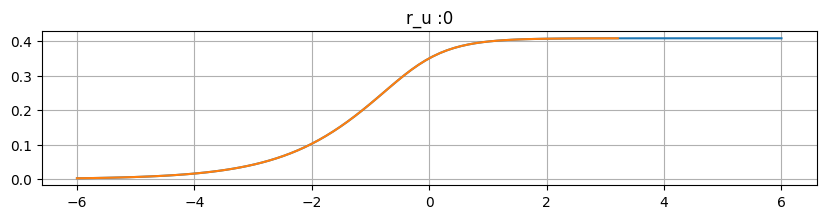

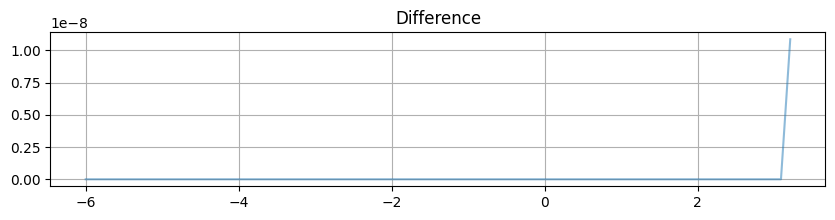

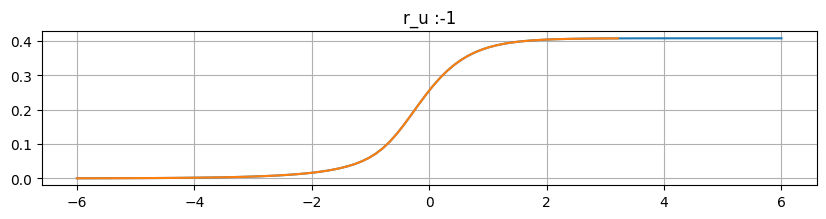

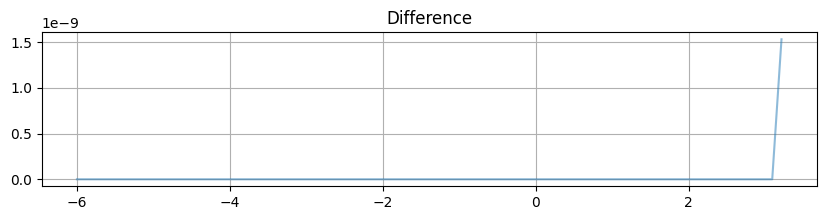

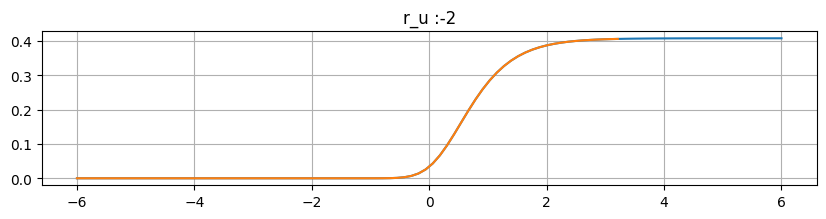

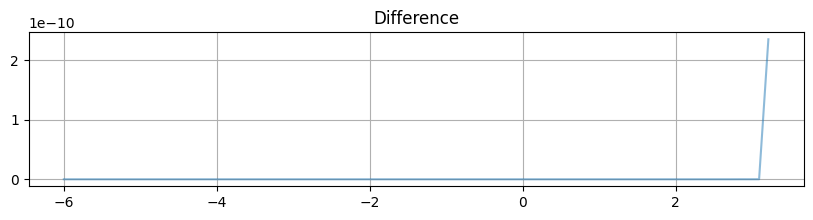

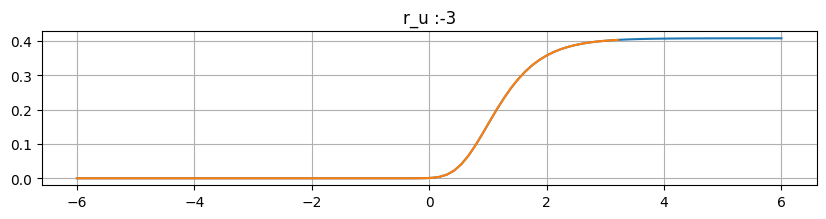

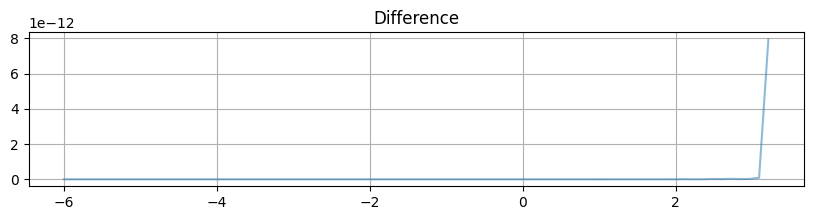

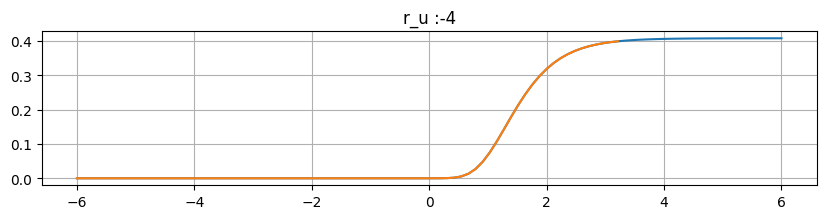

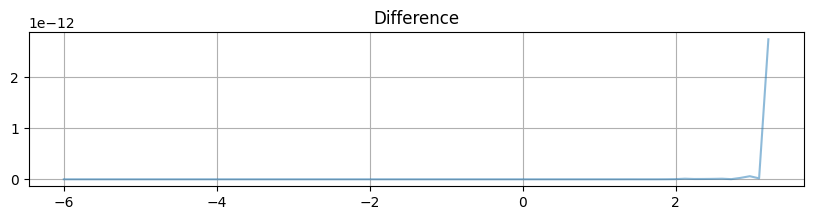

done


In [ ]:
import numpy as np
from scipy.integrate import quad
from scipy.special import erf, erfc
import torch
import matplotlib.pyplot as plt

def integral_quad(h, r_u, scales):
    def _integrand(r, s):
        return np.exp((r-1)*h - ((r-1)-r_u)**2/s**2)
    results = []
    for s in scales:
        val, _ = quad(_integrand, 0, 1, args=(s,))
        results.append(val)
    return np.array(results)

def get_log_erf_diff(a, b):
    log_diff = np.log(erfc(b)) + np.log((1 - np.exp(np.log(erfc(a))-np.log(erfc(b)))))
    return log_diff
    
def integral_closed(h, r_u, scales):
    upper = r_u/scales + scales*h/2 + 1/scales
    lower = r_u/scales + scales*h/2
    log_diff = get_log_erf_diff(upper, lower)
    log1 = (scales**2*h**2/4 + h*r_u)
    log2 = np.log(np.sqrt(np.pi)*scales/2)
    log3 = log_diff
    return np.exp(log1 + log2 + log3)

def get_log_erf_diff_torch(a, b):
    log_diff = torch.log(torch.erfc(b)) + torch.log((1.0 - torch.exp(torch.log(torch.erfc(a))-torch.log(torch.erfc(b)))))
    #log_diff = torch.log(torch.erfc(b)) + torch.log(-torch.expm1(torch.log(torch.erfc(a))-torch.log(torch.erfc(b))))
    return log_diff
    
def integral_closed_torch(h, r_u, scales):
    h = torch.tensor(h, device='cuda:0', dtype=torch.float64)
    r_u = torch.tensor(r_u, device='cuda:0', dtype=torch.float64)
    scales = torch.tensor(scales, device='cuda:0', dtype=torch.float64)

    upper = r_u/scales + scales*h/2 + 1/scales
    lower = r_u/scales + scales*h/2
    log_diff = get_log_erf_diff_torch(upper, lower)
    log1 = (scales**2*h**2/4 + h*r_u)
    log2 = torch.log(np.sqrt(np.pi)*scales/2)
    log3 = log_diff
    return torch.exp(log1 + log2 + log3).data.cpu().numpy()

lambda_0 = -5.0778
lambda_1 = 5.7618

NFE = 5
h = (lambda_1 - lambda_0) / NFE
log_scales = np.linspace(-6, 6, 100)
scales = np.exp(log_scales)

for r_u in range(0, -5, -1):
    int_quad = integral_quad(h, r_u, scales)
    #int_closed = integral_closed(h, r_u, scales)
    int_closed_torch = integral_closed_torch(h, r_u, scales)
    
    plt.figure(figsize=[10, 2])
    plt.title('r_u :' + str(r_u))
    plt.plot(log_scales, int_quad, label='quad')
    #plt.plot(log_scales, int_closed, label='closed')
    plt.plot(log_scales, int_closed_torch, label='closed torch')
    plt.grid()
    plt.show()

    plt.figure(figsize=[10, 2])
    plt.title('Difference')
    #plt.plot(log_scales, np.abs(int_quad - int_closed), label='difference', alpha=0.5)
    plt.plot(log_scales, np.abs(int_quad - int_closed_torch), label='difference', alpha=0.5)
    plt.grid()
    plt.show()
print('done')